Dealing with Class Imbalance
===

Author: Nathan A. Mahynski

Date: 2023/09/06

Description: What to do when we have imbalanced classes?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/gallery/imbalanced_classes.ipynb)

When building classifiers, class imbalance in the training set can significantly affect the quality of your final model.  If a set is 80% A and 20% B, then a simple majority classifier (predict everything to be A) will have an 80% accuracy.  However, this is neither sensical, nor necessarily relevant for the real world if the balance is skewed relative to what is to be expected.  Dealing with class imbalance has been, and continues to be, the subject of much research, but there are many existing tools which can handle this problem reasonably well.

However, authentication is not the same as classification and it is important that class imbalance be understood in the proper context when doing authentication.

<h3>Option 1: Choose a better metric</h3>

First of all, you can consider using an alternative metric to accuracy.  The metric of accuracy has issues when a majority class dominates (as illustrated above); other metrics like precision or recall might be more helpful depending on your application. 

<h3>Option 2: Weight data points by their inverse frequency</h3>

Second, there are class balancing tools available <i>in-situ</i> in many machine learning models. For example, [trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree#sklearn.tree.DecisionTreeClassifier) and [SVCs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) can weight the error of misprediction by the inverse of class frequency in the training set.  scikit-learn implements these as the `class_weight=balanced` option - refer to the documentation for more details.  This is particularly nice since methods based on ensembles of these atomic classifiers, like random forests, also inherit this built in capability.  Since RF's are almost always one of, if not the best, method for classifying dense, tabular data we can often rely on this feature; it can even be treated as hyperparameter during cross validation to test its importance and impact automatically.  

<h3>Option 3: Re-sampling</h3>

Unfortunately, not all models can handle this.  Unsupervised methods (e.g., PCA) in particular ignore class labels and if one class is highly sampled the data structure can be biased toward that region of latent space, resulting in what will usually become a poor model in production.  As a result, you must resort to other methods to balance the classes which will allow you more fairly compare pipelines involving classifiers that cannot automatically balance classes with those that can.  These methods generally involve re-sampling the dataset, but there are a number of different ways to do so.

<h4>Data Duplication</h4>

The simplest is to simply [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html?highlight=resample) (draw with replacement) the minority classes until all classes have the same number of data point. This is referred to as "oversampling" since it boosts the minority classes. However, the repeated reuse of the data can amplify bias toward these specific observations.  It is also possible to undersample the majority class(es) by randomly removing some points.  Generally, the latter is less popular since data is usually very precious and we want to make as much use of it as possible.  It is also common practice to combine the two to shrink the majority class(es) a little, and amplify the minority class(es) a little so they meet somewhere in the middle.

<h4>Synthetic Data</h4>

Instead of re-using "real" data, it is also possible to create synthetic data.  There are a number of approaches, but perhaps the most common is [Synthetic Minority Over-sampling TEchnique (SMOTE)](http://www.jair.org/index.php/jair/article/view/10302); a nice python library called [imblearn](https://imbalanced-learn.org/stable/index.html) implements this, and alternatives, and has excellent examples and tutorials. SMOTE works by looking at the `k` nearest neighbors of a point (which belong to the same class), selecting one randomly, then choosing a random distance to move along the vector connecting the two, essentially interpolating between them.  There are a number of variants of SMOTE, but the vanilla version is common; it does have a number of issues, though:

1. It is unclear what value of `k` to choose, and also, this imposes a minimum number of examples that must be in a dataset (e.g., `k`=10 won't work if you only have 9 observations of a class).

2. It uses Euclidean distance, which (usually) means features need to be on the same scale to make sense.

3. It results in a "stringy" datasets where points follow "lines" between points which is a bit artificial; moreover, noise is introduced when points of classes are very near each other and tend to make it harder to recognize decision boundaries.

The first point is relatively simple to solve if you treat `k` as a hyperparameter and optimize it with cross-validation.  This means that SMOTE should really be part of your overall data modeling pipeline, not just a single preprocessing step.  With enough data, you can split the data into test/train sets; then, you should balance <b>only the training set</b> - we wish to train on data that doesn't bias the model fitting, but we need to look at only the real world data to assess.  If you generated synthetic data for testing you cannot be sure those points are meaningful.  The test data should always remain imbalanced so the model is evaluated on "real" data only. `imblearn` handles this behind the scenes automatically, and is a drop-in replacement for `sklearn`'s pipeline.

The second point can actually be solved by standardizing the data before using SMOTE; this essentially non-dimensionalizes (autoscales) the data and places it all on the same scale.  For example, if you have a feature of height in millimeters, and weight in kilograms where people are being measured, the height feature will have a much larger magnitude.  SMOTE uses Euclidean distance to determine the nearest neighbors, so in this case differences in weight appear very small relative to height variations; the `k` nearest neighbors would really just be the `k` nearest samples with most similar height.  Thus, the data would make a certain minority class seem like they all have very similar heights, which could very easily confuse a model trained on that data.  The solution is (1) standardize, then (2) SMOTE resample, then (3) de-standardize so the resulting dataset now has synthethic data in its original units, but which has been resampled in a more even fashion across the features.  It is also important to stratify your test/train sets as well.  A final note is that outliers can affect standardization so [robust scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) can be preferable to "standard scaling".

The third problem can be solved by combining the oversampling with undersampling. [imblearn](https://imbalanced-learn.org/stable/index.html) currently implements 2 different methods: Tomek's links and edited nearest neighbors.  While subjective, [SMOTE-ENN](https://imbalanced-learn.org/stable/combine.html#combine) tends to clean up more noisy (re)samples than using Tomek's links</a>.  Refer to their documentation for more information.

Additional References:

* [Wikipedia](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis)

* [smote_variants](https://github.com/analyticalmindsltd/smote_variants) python mpackage

* [Lemaître, G. Nogueira, F. Aridas, Ch.K. (2017) Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning, Journal of Machine Learning Research, vol. 18, no. 17, 2017, pp. 1-5.](http://www.jmlr.org/papers/volume18/16-365/16-365.pdf)

* [Chawla, Nitesh V.; Herrera, Francisco; Garcia, Salvador; Fernandez, Alberto (2018-04-20). "SMOTE for Learning from Imbalanced Data: Progress and Challenges, Marking the 15-year Anniversary". Journal of Artificial Intelligence Research. 61: 863–905. doi:10.1613/jair.1.11192. ISSN 1076-9757.](https://doi.org/10.1613%2Fjair.1.11192)

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install dtale

    import dtale.app as dtale_app
    dtale_app.USE_COLAB = True
else:
    import dtale
    
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import imblearn

import numpy as np
import pandas as pd

from IPython.display import Image

from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay

from pychemauth.preprocessing.imbalanced import ScaledSMOTEENN
from pychemauth.preprocessing.scaling import RobustScaler
from pychemauth.classifier.simca import SIMCA_Authenticator

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours as ENN

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

sklearn   : 1.3.0
matplotlib: 3.7.2
numpy     : 1.24.4
watermark : 2.4.3
pandas    : 2.0.3
imblearn  : 0.11.0
pychemauth: 0.0.0b3
dtale     : 3.3.0
json      : 2.0.9



<h3>Create some Imbalanced Data</h3>

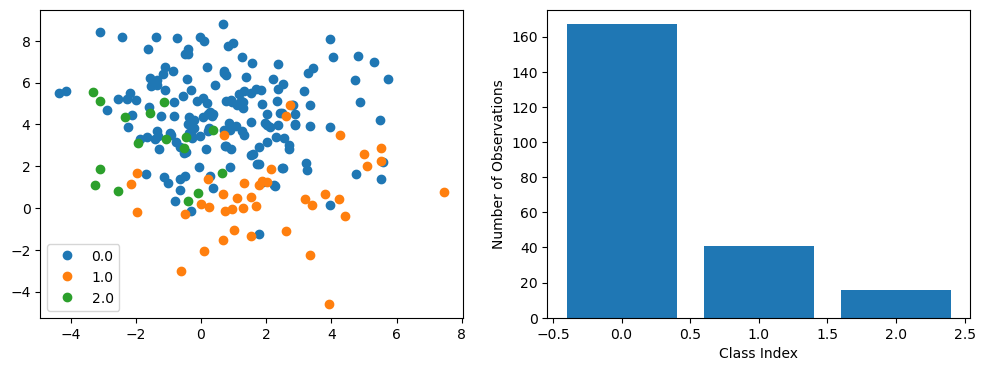

In [4]:
# Generate a random, balanced set
X, Y = sklearn.datasets.make_blobs(n_samples=500, 
                                   n_features=2, 
                                   centers=None, 
                                   cluster_std=2,  
                                   shuffle=True, 
                                   random_state=0)

# Imbalance the set
np.random.seed(0)

scale_down = [1.0, 0.25, 0.1]
X_imb = np.zeros((0,2))
y_imb = []
for i,class_ in enumerate(sorted(np.unique(Y))):
    mask = Y == class_
    limit = int(np.sum(mask)*scale_down[i])
    x_, y_ = X[mask][:limit], Y[mask][:limit]
    
    X_imb = np.concatenate((X_imb, x_))
    y_imb = np.concatenate((y_imb, y_))
    
# Visualize the dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for class_ in sorted(np.unique(y_imb)):
    mask = y_imb == class_
    axes[0].plot(X_imb[mask,0], X_imb[mask,1], 'o', label=class_)
_ = axes[0].legend(loc='best')

values, counts = np.unique(y_imb, return_counts=True)
axes[1].bar(x=values, height=counts)
axes[1].set_xlabel('Class Index')
_ =axes[1].set_ylabel('Number of Observations')

Using In-Situ Methods
---

A number of sklearn classifiers have a parameter called `class_weight` which can be used to weight the mistakes made on each class by how often they (do not) appear.  Refer to each class' documentation for details.

In [5]:
def plot_decision_regions(X, y, classifier, ax, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('C0', 'C1', 'C2', 'C3', 'C4')

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    disp = DecisionBoundaryDisplay.from_estimator(
        estimator=classifier, 
        X=np.array([xx1.ravel(), xx2.ravel()]).T, 
        grid_resolution=500, 
        eps=1.0, 
        plot_method='contourf', 
        response_method='auto', 
        xlabel=None, ylabel=None, ax=ax)
    
    for idx, cl in enumerate(np.unique(y)):
        disp.ax_.scatter(
            x=X[y == cl, 0], 
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx], 
            label=cl
        )
        
    disp.ax_.legend(loc='best')

In [6]:
def compare(X, y, report=True):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    for ax, class_weight in zip(axes.ravel(), [None, 'balanced']):
        log_reg = Pipeline(steps=[
            ('scaler', StandardScaler(with_mean=True, with_std=True)),
            ('model', LogisticRegression(
                penalty=None, 
                random_state=0, 
                class_weight=class_weight # Weight based on the class frequency
            ))
        ])

        log_reg.fit(X, y)

        plot_decision_regions(X, y, log_reg, ax)
        ax.set_title("Model Intrinsically Imbalanced" if not class_weight else "Model Intrinsically Balanced")
        
        if report:
            print(classification_report(y, log_reg.predict(X)))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       167
         1.0       0.72      0.68      0.70        41
         2.0       0.50      0.19      0.27        16

    accuracy                           0.83       224
   macro avg       0.70      0.60      0.62       224
weighted avg       0.82      0.83      0.82       224

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81       167
         1.0       0.62      0.83      0.71        41
         2.0       0.24      0.69      0.36        16

    accuracy                           0.73       224
   macro avg       0.60      0.74      0.63       224
weighted avg       0.84      0.73      0.76       224



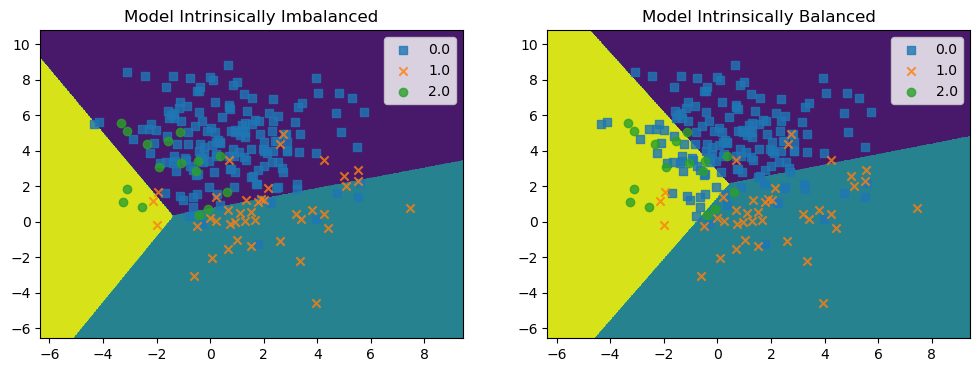

In [7]:
compare(X_imb, y_imb)

Re-sampling Methods
---

<h3>Simple Re-sampling</h3>

We could also perform "random resampling" akin to bootstrapping, where we randomly choose points from one or more minority classes to repeat in the dataset.

In [8]:
# Let's just resample the smallest class (2) - in principle, you can do this to all class not the majority
Xr, yr = resample(X_imb[y_imb==2], # Resample X with y == 2
                  y_imb[y_imb==2], 
                  replace=True, # Sample with replacement
                  n_samples=np.sum(y_imb==0) - np.sum(y_imb==2), # Choose the number of samples to match the majority class
                  random_state=0,
                 )
X_bal = np.concatenate((X_imb, Xr))
y_bal = np.concatenate((y_imb, yr))

              precision    recall  f1-score   support

         0.0       0.78      0.75      0.76       167
         1.0       0.77      0.66      0.71        41
         2.0       0.78      0.84      0.81       167

    accuracy                           0.78       375
   macro avg       0.78      0.75      0.76       375
weighted avg       0.78      0.78      0.78       375

              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77       167
         1.0       0.44      0.83      0.57        41
         2.0       0.78      0.75      0.77       167

    accuracy                           0.74       375
   macro avg       0.69      0.76      0.70       375
weighted avg       0.78      0.74      0.75       375



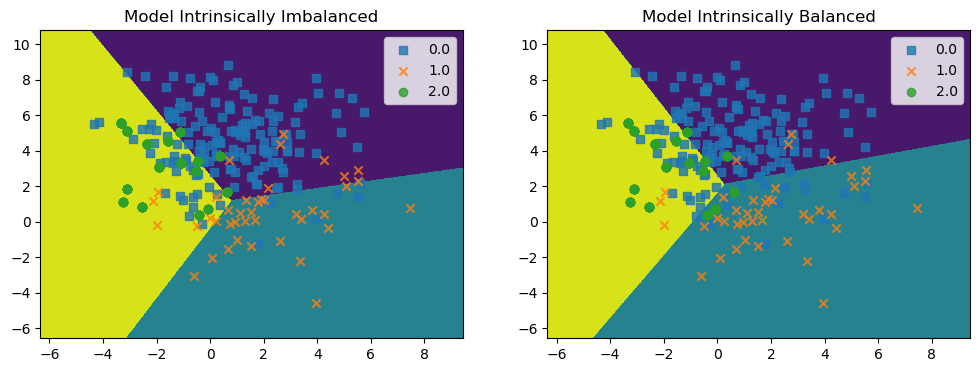

In [9]:
compare(X_bal, y_bal)

Note the boundary between classes 0 and 2 has not shifted on internal balancing because those two are in equal proportion. Oly the boundary between class 1 and 2 and class 1 and 3 shift.  No "new" points appear above because we have simple re-used the same points over and over again.

<h3>SMOTE</h3>

SMOTE works by taking pairs of points from the minority class (determined by k nearest neighbors) and interpolating between them to create a synthetic datapoint.  The image below from the [imblearn](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn) documentation illustrates this concept:

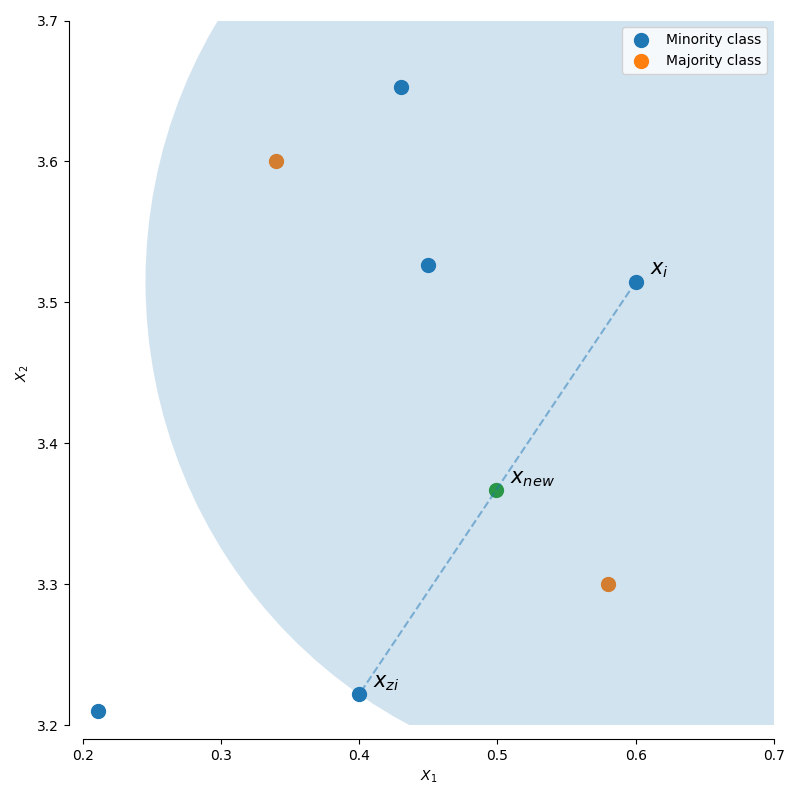

In [10]:
Image(filename='../../_static/imblearn_generation.png', width=500)

<h4>A Manual Implementation</h4>

We can write some python code to manually implement SMOTE for a better understanding.

In [11]:
def my_smote(X, y, k=5, seed=0):
    """In this version, we resample all classes except the majority one."""
    np.random.seed(seed)
    
    # What is the majority class?
    majority_class = sorted(zip(*np.unique(y, return_counts=True)), key=lambda x:x[1], reverse=True)[0][0]
    n_majority = np.sum(y == majority_class)
    
    X_balanced = np.zeros((0, X.shape[1]))
    y_balanced = np.zeros((0,))
    for class_ in sorted(np.unique(y)):
        mask = y == class_
        if class_ != majority_class:
            # Fit nearest neighbor model
            k_nearest = NearestNeighbors(
                n_neighbors=k, # Find k nearest neighbors
                p=2 # Euclidean distance
            )
            k_nearest.fit(X[mask])
        
            # Copy what we already have
            X_up = X[mask].copy().tolist()
            
            # Generate new points to make up the difference
            num_to_add = n_majority - np.sum(mask) # How many points do we need to add?
            for i in range(num_to_add):
                # 1. Select a random point
                idx = np.random.randint(0, np.sum(mask)-1)
                start = X[mask][idx]
                nebrs_dist, nebrs_idx = k_nearest.kneighbors([start])
                
                # 2. Select a random neighbor
                idx = np.random.randint(0, len(nebrs_idx[0])-1)
                end = X[mask][nebrs_idx[0][idx]]
                                           
                # 3. Select random point along vector between the two
                X_up.append(np.random.random()*(end - start) + start)
            
            y_up = np.array([class_]*n_majority)
            X_up = np.array(X_up)
        else:
            # Do nothing to majority class
            y_up = y[mask]
            X_up = X[mask]
            
        X_balanced = np.concatenate((X_balanced, X_up))
        y_balanced = np.concatenate((y_balanced, y_up))
            
    return X_balanced, y_balanced

In [12]:
X_balanced, y_balanced = my_smote(X_imb, y_imb, k=5, seed=0)

              precision    recall  f1-score   support

         0.0       0.78      0.69      0.73       167
         1.0       0.79      0.84      0.81       167
         2.0       0.76      0.80      0.78       167

    accuracy                           0.78       501
   macro avg       0.78      0.78      0.78       501
weighted avg       0.78      0.78      0.78       501

              precision    recall  f1-score   support

         0.0       0.78      0.69      0.73       167
         1.0       0.79      0.84      0.81       167
         2.0       0.76      0.80      0.78       167

    accuracy                           0.78       501
   macro avg       0.78      0.78      0.78       501
weighted avg       0.78      0.78      0.78       501



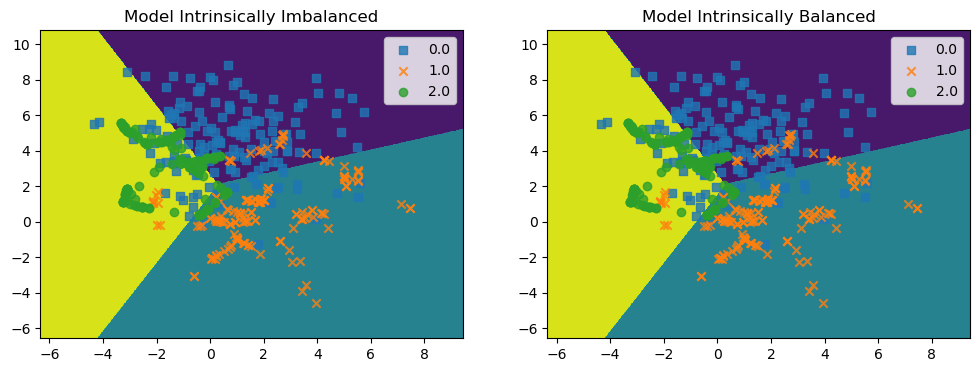

In [13]:
compare(X_balanced, y_balanced) # Internal balancing does nothing because all classes have the same number of points

Note how the points above "string-like" clusters - this is because of how SMOTE generates synthetic data.

<h4>SMOTEENN</h4>

In [14]:
# imblearn provides an implementation we can use directly.
smote = SMOTE(
    random_state=0,
    k_neighbors=5,
    sampling_strategy='not majority',
)

X_balanced, y_balanced = smote.fit_resample(X_imb, y_imb)

              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72       167
         1.0       0.78      0.84      0.81       167
         2.0       0.72      0.73      0.72       167

    accuracy                           0.75       501
   macro avg       0.75      0.75      0.75       501
weighted avg       0.75      0.75      0.75       501

              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72       167
         1.0       0.78      0.84      0.81       167
         2.0       0.72      0.73      0.72       167

    accuracy                           0.75       501
   macro avg       0.75      0.75      0.75       501
weighted avg       0.75      0.75      0.75       501



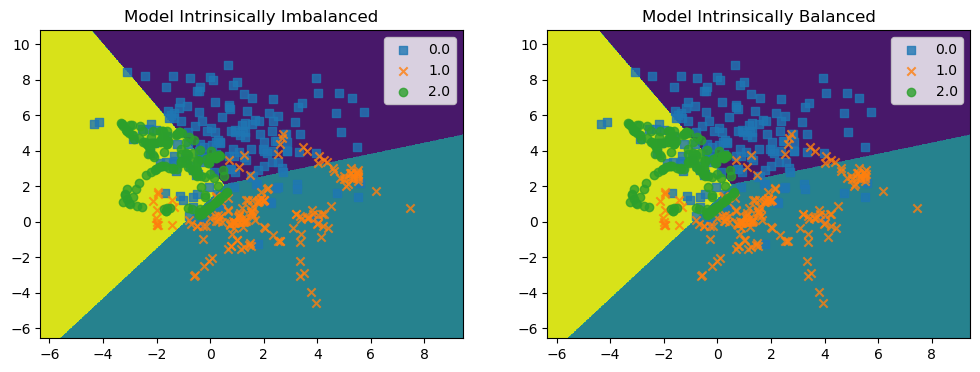

In [15]:
compare(X_balanced, y_balanced)

One problem with SMOTE is that it can choose to draw a connection between inliers and (marginal) outliers.  This noise should optimally be removed somehow.  There are 2 main methods implemented in imblearn which are using Tomek's links and edited nearest neighbors. See the [imblearn documentation](https://imbalanced-learn.org/stable/combine.html) for more examples and discussion.  This combination of under and over sampling is generally optimal.

According to [imblearn's documentation](https://imbalanced-learn.org/stable/under_sampling.html):

> "`EditedNearestNeighbours` applies a nearest-neighbors algorithm and “edit” the dataset by removing samples which do not agree “enough” with their neighboorhood. For each sample in the class to be under-sampled, the nearest-neighbours are computed and if the selection criterion is not fulfilled, the sample is removed. Two selection criteria are currently available: (i) the majority (i.e., kind_sel='mode') or (ii) all (i.e., kind_sel='all') the nearest-neighbors have to belong to the same class than the sample inspected to keep it in the dataset:"

**Note that this means that, unlike vanilla SMOTE, all classes do not have exactly the same number of observations.**

In [16]:
sm = SMOTEENN(
    sampling_strategy='not majority',
    random_state=0,
    smote=SMOTE(
        random_state=0,
        k_neighbors=5,
        sampling_strategy='not majority',
    ),
    enn=ENN(
        sampling_strategy='not majority',
        n_neighbors=5,
        kind_sel='mode',
    ),
)

X_balanced, y_balanced = sm.fit_resample(X_imb, y_imb)

In [17]:
# There is still class imbalance, but not nearly as much
np.unique(y_balanced, return_counts=True)

(array([0., 1., 2.]), array([167, 147, 156]))

              precision    recall  f1-score   support

         0.0       0.84      0.72      0.78       167
         1.0       0.80      0.90      0.85       147
         2.0       0.74      0.76      0.75       156

    accuracy                           0.79       470
   macro avg       0.80      0.80      0.79       470
weighted avg       0.80      0.79      0.79       470

              precision    recall  f1-score   support

         0.0       0.85      0.72      0.78       167
         1.0       0.80      0.91      0.85       147
         2.0       0.74      0.76      0.75       156

    accuracy                           0.80       470
   macro avg       0.80      0.80      0.80       470
weighted avg       0.80      0.80      0.79       470



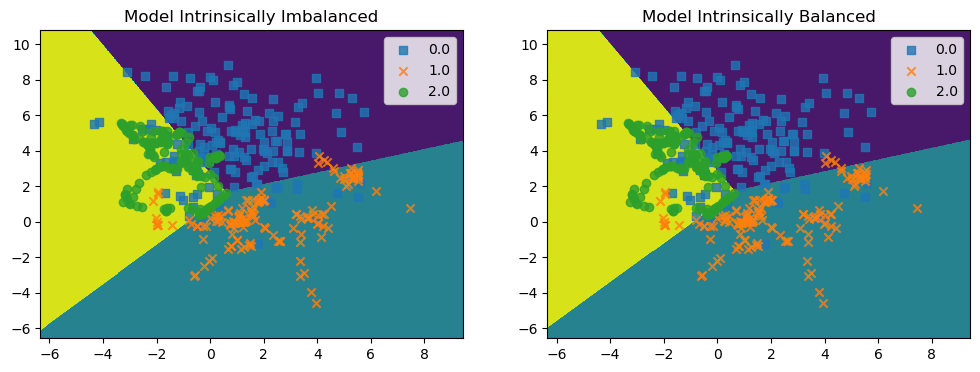

In [18]:
compare(X_balanced, y_balanced) # Slight differences because classes are not perfectly balanced

Compare these images to when we used SMOTE only.  You will notice the classes are less overlapped now!

In [19]:
# The data provided here is all on the same scale so let's artificially increase the scale of the first column
# to compare what happens if we do not autoscale before using SMOTE.

X_imb_bad_scale = X_imb.copy()
X_imb_bad_scale[:,0] = X_imb[:,0]*10

In [20]:
sm_scaled = ScaledSMOTEENN(
    sampling_strategy_smoteenn='not majority',
    sampling_strategy_smote='not majority',
    sampling_strategy_enn='not majority',
    k_smote=5,
    k_enn=5,
    kind_sel_enn='mode',
    random_state=0,
    scaler=RobustScaler(),
)

In [21]:
X_balanced_scaled, y_balanced_scaled = sm_scaled.fit_resample(X_imb_bad_scale, y_imb)
X_balanced, y_balanced = sm.fit_resample(X_imb_bad_scale, y_imb)

In [22]:
# There is still class imbalance, but not nearly as much
np.unique(y_balanced, return_counts=True)

(array([0., 1., 2.]), array([167, 146, 156]))

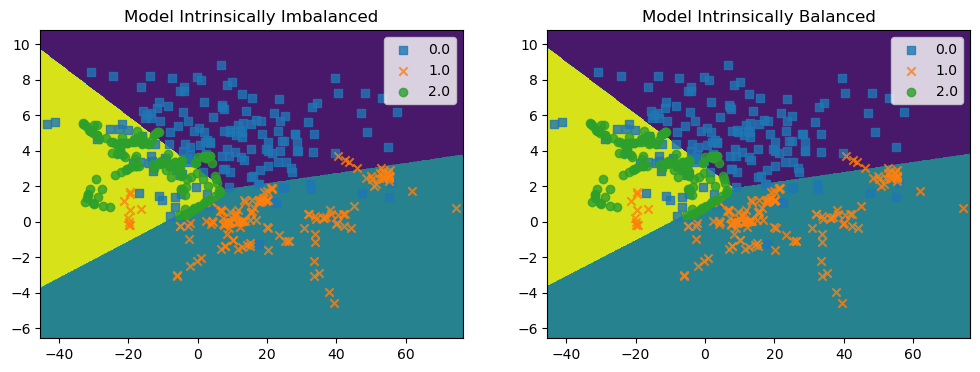

In [23]:
# This looks essentially identical to previous results because previously features were on a similar scale, and here
# we ensured that by using autoscaling, then using SMOTE, then scaling back to the original feature space.
compare(X_balanced_scaled, y_balanced_scaled, report=False)

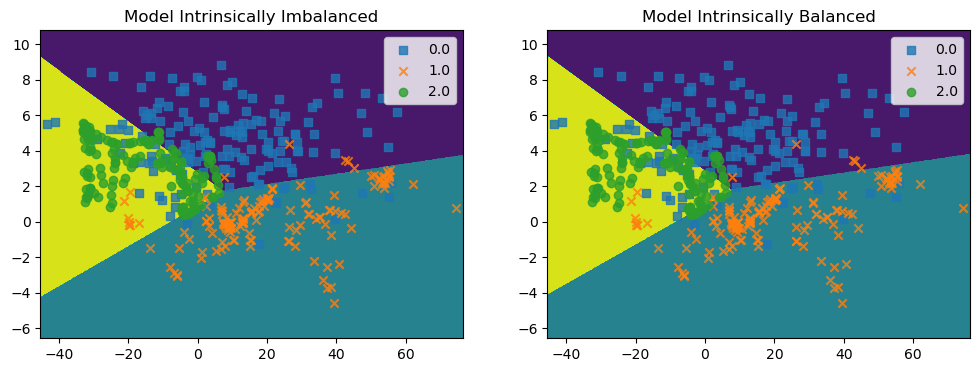

In [24]:
# If we ignore the scale, we now see that the imputations tend be more "vertically stringy" because points have been 
# stretched in the horizonal (X) direction so KNN is picking points that have the most similar X values, emphasizing 
# interpolation in the (Y) direction.
compare(X_balanced, y_balanced, report=False)

Using Balancing in a Pipeline
---

Setting class_balance parameters is trivial inside a gridsearch cv object, using smote can be just as simple. Resampling should occur only on the training set, not the test set so we will use imblearn pipelines.

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_imb,
    y_imb, 
    shuffle=True,
    random_state=42,
    test_size=0.3,
    stratify=y_imb # It is usually important to balance the test and train set so they have the same fraction of classes
)

In [26]:
pipeline = Pipeline(steps=[
    ("smote", ScaledSMOTEENN(random_state=1)),
    ("scaler", RobustScaler(with_median=True, with_iqr=True)),
    ("log_reg", LogisticRegression(penalty=None, 
                   random_state=0, 
                   class_weight=None
                  )
    )
])

param_grid = [{
    'smote__k_enn':[1, 3, 5],
    'smote__k_smote':[1, 3, 5],
    'smote__kind_sel_enn':['all', 'mode'],
    'log_reg__class_weight':[None, 'balanced']
}]

gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  n_jobs=-1,
                  refit=True,
                  cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
                 )

_ = gs.fit(X_train, y_train)

In [27]:
gs.best_params_

{'log_reg__class_weight': 'balanced',
 'smote__k_enn': 1,
 'smote__k_smote': 1,
 'smote__kind_sel_enn': 'all'}

In [28]:
print(classification_report(y_test, gs.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.91      0.63      0.74        51
         1.0       0.58      0.58      0.58        12
         2.0       0.19      0.80      0.31         5

    accuracy                           0.63        68
   macro avg       0.56      0.67      0.55        68
weighted avg       0.80      0.63      0.68        68



Class Balancing in Authentication
---

Class imbalance affects authentication models in a different way from conventional classification ones.  If a model is trained in a "rigorous" way, then hyperparameters are adjusted so that a certain type I error rate is achieved; these models use only examples of the positive class during training, so by definition, **class imbalance does not exist.**  Conversely, if a model is trained in a "compliant" way, the model is optimized to achieved the best possible metric, often total efficiency (which reflects a balance between specificity and sensitivity).  In this case, non-members of a class are used to measure how well a model rejects foreign samples; thus, class imbalance can impact the accuracy of this measurement.  However, this is still biased by the specific foreign members used, and having more foreign examples does not necessarily improve the overall model. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imb,
    y_imb, 
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y_imb # It is usually important to balance the test and train set so they have the same fraction of classes
)

In [30]:
def train_pipeline(model_class, use_smote=True, style='compliant'):
    steps = []
    param_grid = {}
    if use_smote:
        steps += [("smote", ScaledSMOTEENN(
            random_state=1,
            sampling_strategy_smoteenn='not majority',
            sampling_strategy_smote='not majority',
            sampling_strategy_enn='not majority',
            scaler=RobustScaler()
        ))]
        param_grid = {
            'smote__k_enn':[1, 5, 7],
            'smote__k_smote':[1, 5, 7],
            'smote__kind_sel_enn':['all', 'mode']
        }
    steps += [
        ("simca", SIMCA_Authenticator(
                n_components=1, 
                alpha=0.05, 
                scale_x=True, 
                style='dd-simca', 
                target_class=model_class, 
                robust='semi',
                use=style
            )
        )
    ]
    param_grid['simca__n_components'] = [1, 2] # In this case we have only 2 features so this is an upper bound
    
    pipeline = Pipeline(steps=steps)
    gs = GridSearchCV(estimator=pipeline,
                      param_grid=param_grid,
                      n_jobs=-1,
                      refit=True,
                      cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
                     )

    _ = gs.fit(X_train, y_train)
    
    return gs

def summarize(modeled_class):
    gs_yes_comp = train_pipeline(model_class=modeled_class, use_smote=True, style='compliant')
    gs_no_comp = train_pipeline(model_class=modeled_class, use_smote=False, style='compliant')
    gs_yes_rig = train_pipeline(model_class=modeled_class, use_smote=True, style='rigorous')
    gs_no_rig = train_pipeline(model_class=modeled_class, use_smote=False, style='rigorous')

    def unroll(gs):
        res = gs.best_estimator_.named_steps['simca'].metrics(X_test, y_test)
        csps_ = []
        for class_ in [0.0, 1.0, 2.0]:
            if class_ in res['csps']:
                csps_.append(res['csps'][class_])
            else:
                csps_.append(np.nan)
        return [res['teff'], res['tsns'], res['tsps']] + csps_
    
    df = pd.DataFrame(
        data=[unroll(gs_no_comp)] + [unroll(gs_yes_comp)] + [unroll(gs_no_rig)] + [unroll(gs_yes_rig)],
        index=['No SMOTE (C)', 'SMOTE (C)', 'No SMOTE (R)', 'SMOTE (R)'],
        columns=['TEFF', 'TSNS', 'TSPS', 'CSPS(0)', 'CSPS(1)', 'CSPS(2)']
    ).T
    
    return df

In [35]:
df_0 = summarize(0)
df_1 = summarize(1)
df_2 = summarize(2)

In [32]:
df_0 

# Class 0 is the majority class - 'not majority' strategies above do not impact the samples of class 0

,No SMOTE (C),SMOTE (C),No SMOTE (R),SMOTE (R)
TEFF,0.575804,0.575804,0.575804,0.575804
TSNS,0.911765,0.911765,0.911765,0.911765
TSPS,0.363636,0.363636,0.363636,0.363636
CSPS(0),NaN,NaN,NaN,NaN
CSPS(1),0.375000,0.375000,0.375000,0.375000
CSPS(2),0.333333,0.333333,0.333333,0.333333


In [33]:
df_1 

# Class 1 is the intermediate class - SMOTE improves specificities at the cost of sensitivities

,No SMOTE (C),SMOTE (C),No SMOTE (R),SMOTE (R)
TEFF,0.699903,0.587022,0.699903,0.578325
TSNS,0.625000,0.375000,0.625000,0.375000
TSPS,0.783784,0.918919,0.783784,0.891892
CSPS(0),0.764706,0.911765,0.764706,0.882353
CSPS(1),NaN,NaN,NaN,NaN
CSPS(2),1.000000,1.000000,1.000000,1.000000


In [34]:
df_2 

# Class 2 is the minority class - SMOTE strongly resamples this class and so the (R) model, which considers only 
# class 2 data is more affected than the (C) model.

,No SMOTE (C),SMOTE (C),No SMOTE (R),SMOTE (R)
TEFF,0.642416,0.617213,0.642416,0.445435
TSNS,0.666667,0.666667,0.666667,0.333333
TSPS,0.619048,0.571429,0.619048,0.595238
CSPS(0),0.617647,0.588235,0.617647,0.588235
CSPS(1),0.625000,0.500000,0.625000,0.625000
CSPS(2),NaN,NaN,NaN,NaN
